# Forecasting orders for a meal kit delivery service 

According to a recent report by grandviewresearch.com, "the global meal kit delivery services market size was valued at USD 10.26 billion in 2020 and is expected to expand at an annual growth rate of 13.0% from 2021 to 2028". One of the major challenges meal kit delivery services face is to accurately forecast and predict customer orders. This is to ensure just enough produce is purchased to serve customer orders while keeping waste at a minimum. Due to the extremely competitive nature of the industry, having an accurate forecasting system in place is essential.

In this analysis, I will be looking at data from a leading meal delivery kit company over 8 weeks in 2020, which shows daily data on customer's meal delivery kit orders and, in particular, optional add-ons that can be purchased on top of the standard meal box. Let's take a look at the data:

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np

daily = pd.read_csv('../addons_daily.csv', parse_dates=['timestamp'], dayfirst=True)
final = pd.read_csv('../addons_final.csv')

In [4]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp       432 non-null    datetime64[ns]
 1   week            432 non-null    object        
 2   production_day  432 non-null    object        
 3   delivery_day    432 non-null    object        
 4   island          432 non-null    object        
 5   fruitboxes      432 non-null    int64         
 6   soups           432 non-null    int64         
 7   sides           432 non-null    int64         
 8   desserts        432 non-null    int64         
 9   lunch           432 non-null    int64         
 10  brunch          432 non-null    int64         
 11  ready-to-heat   192 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(6), object(4)
memory usage: 40.6+ KB


In [5]:
daily.head(10)

,timestamp,week,production_day,delivery_day,island,fruitboxes,soups,sides,desserts,lunch,brunch,ready-to-heat
0,2020-06-11 09:00:00,2020-W25,Friday,Saturday,North,17,62,50,123,13,18,NaN
1,2020-06-11 09:00:00,2020-W25,Friday,Sunday,South,11,41,35,84,9,12,NaN
2,2020-06-11 09:00:00,2020-W25,Saturday,Sunday,North,22,80,66,161,17,23,NaN
3,2020-06-11 09:00:00,2020-W25,Sunday,Monday,North,6,35,26,74,5,8,NaN
4,2020-06-11 09:00:00,2020-W25,Monday,Tuesday,South,8,26,25,53,5,8,NaN
5,2020-06-11 09:00:00,2020-W25,Monday,Tuesday,North,19,62,59,125,13,20,NaN
6,2020-06-11 09:00:00,2020-W25,Tuesday,Wednesday,North,5,24,25,40,9,4,NaN
7,2020-06-11 09:00:00,2020-W25,Wednesday,Thursday,North,3,3,12,17,2,7,NaN
8,2020-06-14 09:00:00,2020-W25,Friday,Saturday,North,26,93,77,156,17,25,NaN
9,2020-06-14 09:00:00,2020-W25,Friday,Sunday,South,19,65,54,110,12,17,NaN


Looking at the table, there appear to be 6 delivery day options for the North island and 2 for the South Island for which customer orders are queried every morning.

Since we are simply trying to predict customer's orders of different add-ons for different delivery dates we can safely remove the production day column. This is of course assumes quality of ingredients remains constant regardless of production date, which seems like a reasonable assumption. Other than that, customer's should not care (or even notice) when their food box has been produced. Therefore any information gathered from this variable would likely be just noise.

In [56]:
daily = daily.drop('production_day',axis=1)
final = final.drop('production_day',axis=1)

To get a better understanding of the weekly order patterns, I will aggregate the daily order data to see if there are any trends, before investigating any differences betweeen delivery days and North and South island customers.

To do this, the dates for the last day of one week and the first day of the following week will have to be separated as they are currently the same. Otherwise a week's last day will also include the first values of the week after.

<AxesSubplot:title={'center':'Aggregate Daily Orders'}, xlabel='timestamp'>

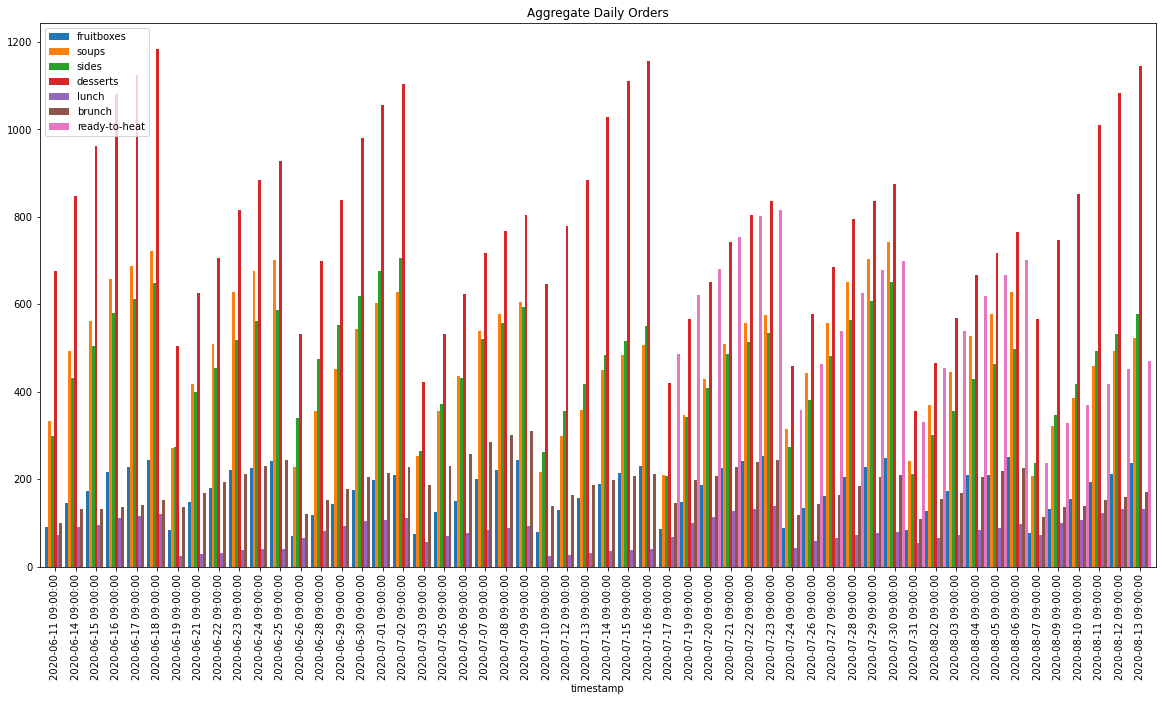

In [7]:
#We need to add dates for the final number days to unique in order to index final_copy correctly:
count=0; date_in=daily.loc[0,'timestamp']
for i in range(0,len(daily)):
    count+=1
    if count==9:
        if daily.loc[i,'timestamp'] == date_in:
            for j in range(8): daily.loc[i+j,'timestamp'] += timedelta(days=1)
            count=1
            date_in = daily.loc[i,'timestamp']
        else: 
            date_in = daily.loc[i,'timestamp']
            count=1

daily_gbt = daily.groupby('timestamp').sum()
daily_gbt.plot(kind='bar',figsize=(20, 10), width=1,title='Aggregate Daily Orders')

It appears that order numbers for each add-on product keep increasing as it gets closer to the delivery date (every six days represent one week). However, at the start of the next week, order numbers are usually around where they started the week before at that time. This suggests that customers typically only order add-on products on a weekly basis rather than permanently including them in their subscription.

That being said, the weekly order patterns still look relatively constant, on average roughly the same number of customers appear to be making the decision to add a particular add-on in any given week. To get a closer look into this, I will group the data by week to confirm this.


<AxesSubplot:title={'center':'Aggregate Weekly Orders'}, xlabel='week'>

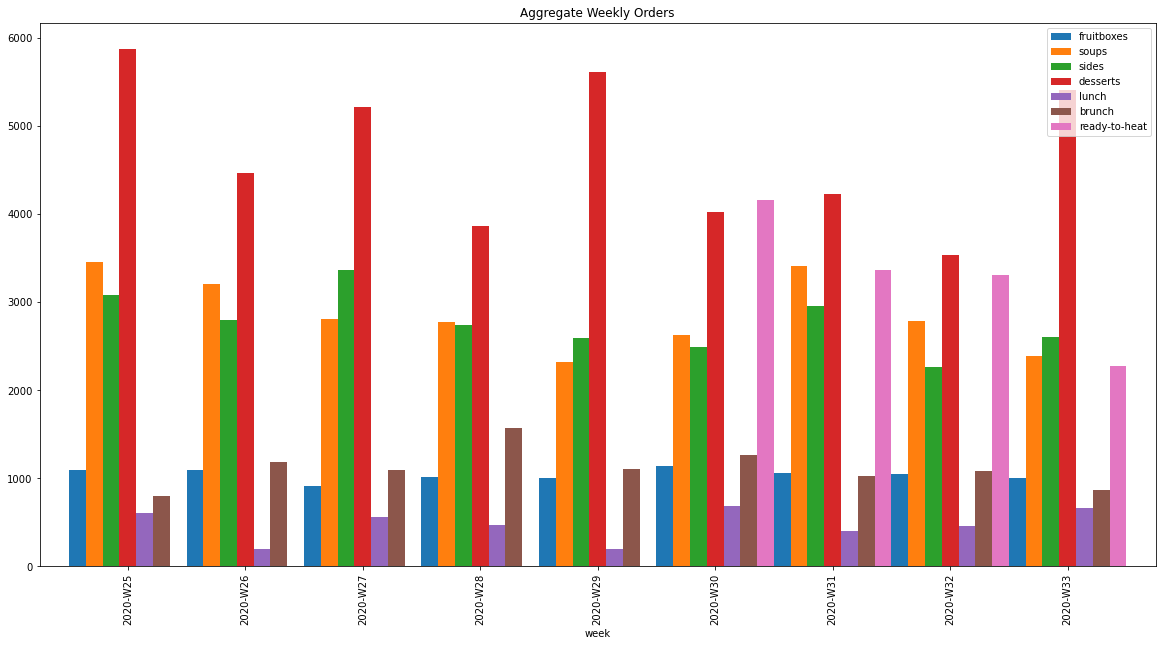

In [8]:
daily_gbw= daily.groupby('week').sum()
daily_gbw.plot(kind='bar',figsize=(20, 10), width=1,title='Aggregate Weekly Orders')

Plotting the data by week appears to confirm the absense of any significant trend, we can see that as ready-to-heat meals get introduced there is a bit of hype for them at first (apparently cannibilising sales for dessert product at the same time). However, by week 33 this seems to have waned of a bit and dessert sale are back to their previous average around 5000 a week.

# Daily and final numbers

Most importantly for predicting final numbers from daily numbers will of course be the relationship between daily and final numbers, overall and for each of the eight different production/ delivery day combinations. 

To get a better understanding of this relationship, I will add final numbers for a couple of weeks to the first graph:

In [9]:
final.head(10)

,week,addon_type,delivery_day,island,box_nr
0,2020-W25,brunch,Saturday,North,24
1,2020-W25,desserts,Saturday,North,197
2,2020-W25,fruitboxes,Saturday,North,43
3,2020-W25,lunch,Saturday,North,22
4,2020-W25,sides,Saturday,North,119
5,2020-W25,soups,Saturday,North,122
6,2020-W25,brunch,Sunday,South,16
7,2020-W25,desserts,Sunday,South,95
8,2020-W25,fruitboxes,Sunday,South,23
9,2020-W25,lunch,Sunday,South,9


In [10]:
#Function to combine daily and final data into one dataframe to make plotting easier
def combine_final(week):
    daily_byweek = daily.loc[daily['week'] == week]
    final_byweek = final.loc[final['week'] == week]

    final_byweek = final_byweek.join(pd.get_dummies(final_byweek.addon_type).mul(final_byweek.box_nr, axis=0)) \
    .drop(['addon_type','box_nr'],axis=1).groupby(['delivery_day','island']).sum()
    add = daily.loc[daily['week'] == '2020-W25'].iloc[0:8,:]
    
    for i in range(len(add)):
        items = final_byweek.loc[add.iloc[i,2],add.iloc[i,3]]
        for j in final_byweek.columns: 
            add.loc[i,j] = items[j]
        add.iloc[i,0] = 'final_'+str(add.iloc[i,2])+'_'+add.iloc[i,3]
        add.iloc[i,1] = week
        
    return daily_byweek.append(add, ignore_index=True)


#Let's choose week 29 and 32:
daily29 = combine_final('2020-W29').set_index('timestamp')
daily32 = combine_final('2020-W32').set_index('timestamp')

<AxesSubplot:title={'center':'Daily and final numbers in Week 29'}, xlabel='timestamp'>

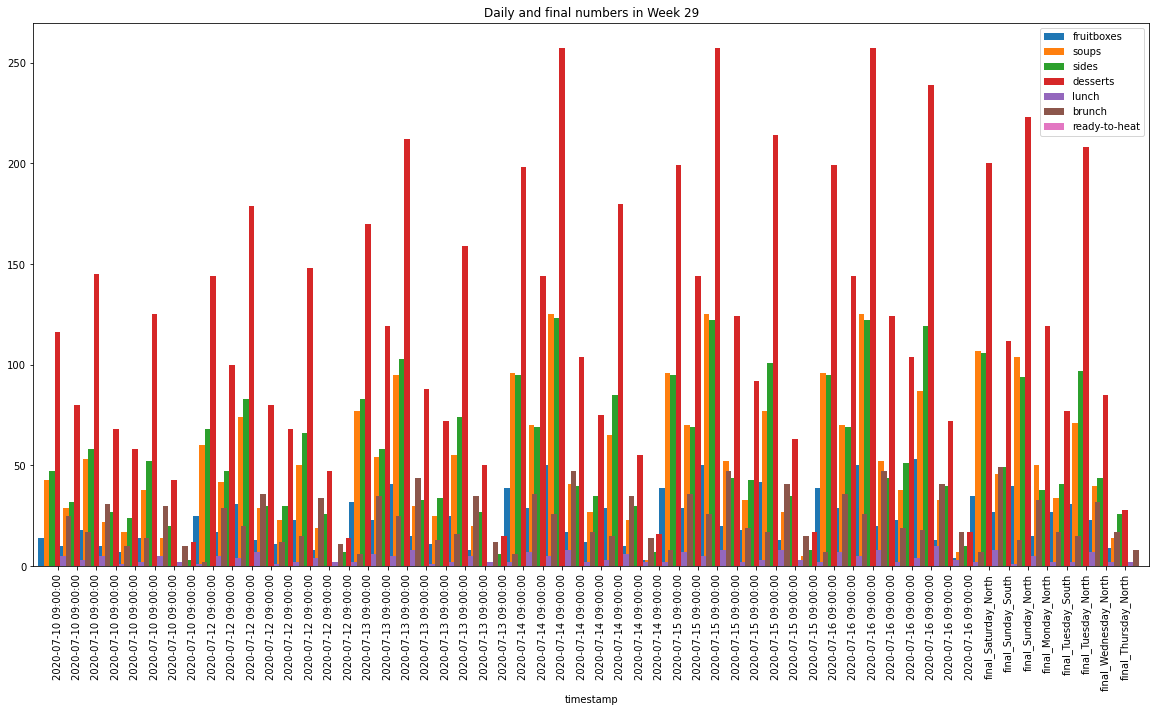

In [11]:
daily29.plot(kind='bar',figsize=(20, 10), width=2,title='Daily and final numbers in Week 29')

It appears that order count generally tends to increase as the week passes. For some delivery dates, orders already plateau on Tuesday (04.08) whereas for others they only peak on the last day (06.08, Thursday). Surprisingly, final numbers appear to be slightly below the daily numbers reported in the last three days before.

Let's see how this compares to week32:

<AxesSubplot:title={'center':'Daily and final numbers in Week 32'}, xlabel='timestamp'>

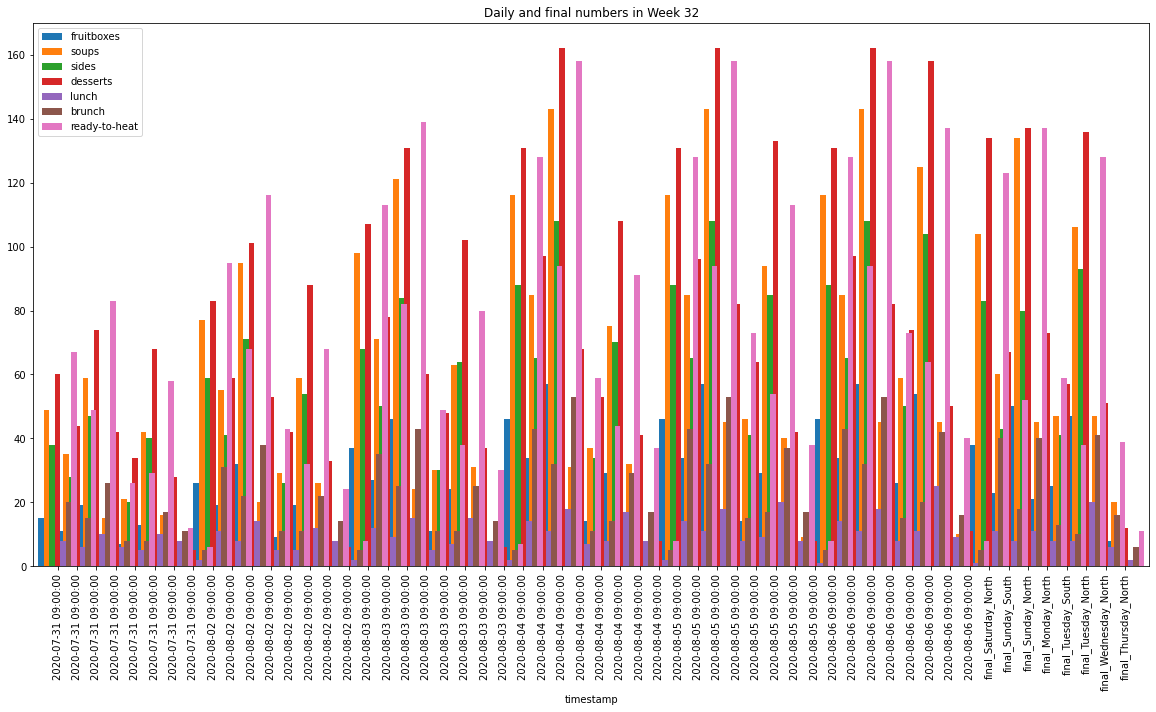

In [12]:
daily32.plot(kind='bar',figsize=(20, 10), width=2,title='Daily and final numbers in Week 32')

The same pattern appears to be happening in week 32, orders plateau around the 4th day of the week and remain relatively stable on the 5th and 6th and then are slightly lower in the final numbers. This is likely due to some last minute cancellations and will be important to keep in mind when forecasting final numbers.

# Fitting a first model to predict Week33 final numbers

Looking at the plots above it appears that the weekly order patterns and the relationship between daily and final values is relatively consistent, without any obvious increasing or decreasing trends.

I will therefore start off by fitting a basic model that takes the only the 6 prior daily numbers of the current week as inputs and outputs an estimate of the final number for each delivery day, island and add-on item. This assumes that only the current week's daily numbers impact the week's final number, and that previous weeks do not. I will investigate whether or not this is a reasonable assumption after fitting the initial model.

This will require some changes to the structure of the data, where each final number for each delivery day/ island/ add-on item combination has its corresponding daily numbers in the same row.

In [7]:
new_cols = ['day1','day2','day3','day4','day5','day6']
for i in new_cols: final[i] = np.zeros(len(final))

final = final.set_index(['week','addon_type','delivery_day','island'])

daily = daily.melt(id_vars=["timestamp", "week","delivery_day","island"], 
        var_name="addon_type", 
        value_name="daily_number")     


unique_days = daily.timestamp.unique()

for i in range(0,len(daily)):
    day = np.where(unique_days==daily.iloc[i,0])[0][0]%6+1
    final.loc[(daily.iloc[i,1],daily.iloc[i,4],daily.iloc[i,2],daily.iloc[i,3]),'day'+str(day)] = daily.iloc[i,5]

final = final.reset_index().fillna(value=0,axis=1)
final.rename(columns={'box_nr':'final_number'}, inplace=True)

#We need to drop week 33's daily numbers from the training set as we don't have final numbers to train it on. 
# Final33 will be needed when making final predictions 
final_pred = final.loc[final['week']!='2020-W33']


In [8]:
final_pred.head()

,week,addon_type,delivery_day,island,production_day,final_number,day1,day2,day3,day4,day5,day6
0,2020-W25,brunch,Saturday,North,Friday,24.0,18,25,26,26,26,26
1,2020-W25,desserts,Saturday,North,Friday,197.0,123,156,181,203,203,203
2,2020-W25,fruitboxes,Saturday,North,Friday,43.0,17,26,33,43,43,43
3,2020-W25,lunch,Saturday,North,Friday,22.0,13,17,19,23,23,23
4,2020-W25,sides,Saturday,North,Friday,119.0,50,77,94,109,109,109


Now the data is in the right format to fit the model. We will predict box_nr based on the values for day1-day6, as well as the categorical variables addon_type, delivery_day and island. To use these in the regression model I convert them to dummy variables which equal 1 if it is the correct category and 0 otherwise.

In [45]:
Xtrain = pd.get_dummies(final_pred.drop(['final_number','week'], axis = 1))  #week is not a significant predictor for the model and I have dropped it therefore
ytrain = final_pred.loc[:,'final_number']

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

LR = LinearRegression()

# We have 7 weeks in the training set, therefore 6 splits should work well
CV_split = TimeSeriesSplit(n_splits=6)
cvs = cross_val_score(LR, Xtrain, ytrain, cv=CV_split, scoring='neg_mean_squared_error')
    
print("Average RMSE for the Linear Model: ",np.sqrt(-cvs).mean())

Average RMSE for the Linear Model:  7.57671607539137


An average RMSE of 7.58 for the linear regression model is a decent place to start. Let's try a few other regression algorithms:

## Fitting a few different regression models

In [16]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor

tree = DecisionTreeRegressor()
knn = KNeighborsRegressor()
rf = RandomForestRegressor()
gbc = GradientBoostingClassifier()


cvs_tree = cross_val_score(tree, Xtrain, ytrain, cv=CV_split, scoring='neg_mean_squared_error')
cvs_knn = cross_val_score(knn, Xtrain, ytrain, cv=CV_split, scoring='neg_mean_squared_error')
cvs_rf = cross_val_score(rf, Xtrain, ytrain, cv=CV_split, scoring='neg_mean_squared_error')
cvs_gbc = cross_val_score(gbc, Xtrain, ytrain, cv=CV_split, scoring='neg_mean_squared_error')


print("Average RMSE for the Decision Tree Model: ",np.sqrt(-cvs_tree).mean())
print("Average RMSE for the KNN Model: ",np.sqrt(-cvs_knn).mean())
print("Average RMSE for the Random Forest Model: ",np.sqrt(-cvs_rf).mean())
print("Average RMSE for the Gradient Boosting Model: ",np.sqrt(-cvs_gbc).mean())

Average RMSE for the Decision Tree Model:  10.336117338580538
Average RMSE for the KNN Model:  9.735898484192559
Average RMSE for the Random Forest Model:  8.057743058404396
Average RMSE for the Gradient Boosting Model:  14.328732500552283


Sometimes simple is better, with the decision tree and random forest models coming close to the linear model, with root mean squared prediction errors of 9.91 and 8.09, respectively. At 7.57 the linear model still performs slightly better however. Going by the Occam's razor principle, simpler is better and I will therefore use the linear model for my final prediction. Let's have a closer look at the components of the linear model:

In [60]:
import statsmodels.api as sm

# Fit and summarize OLS model
mod = sm.OLS(ytrain, Xtrain.drop(['day1','day5','day3','day2','day4',
                                  'addon_type_fruitboxes','addon_type_sides',
                                  'addon_type_lunch','addon_type_desserts','delivery_day_Monday',
                                  'addon_type_ready-to-heat',
                                  'island_North','delivery_day_Tuesday'],axis=1))

res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           final_number   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                              5987.
Date:                Thu, 23 Sep 2021   Prob (F-statistic):                        0.00
Time:                        10:02:46   Log-Likelihood:                         -1475.6
No. Observations:                 448   AIC:                                      2967.
Df Residuals:                     440   BIC:                                      3000.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
day6                       0.8958      0.005    164.477      0.000       0.885       0.907
addon_type_brunch         -1.8083      0.873     -2.072      0.039      -3.524      -0.093
addon_type_soups           2.4168      0.916      2.639      0.009       0.617       4.217
delivery_day_Saturday      6.8477      0.971      7.049      0.000       4.939       8.757
delivery_day_Sunday       -5.2777      0.810     -6.519      0.000      -6.869      -3.687
delivery_day_Thursday      3.8869      0.899      4.326      0.000       2.121       5.653
delivery_day_Wednesday     4.2263      0.906      4.663      0.000       2.445       6.008
island_South              -4.8766      0.729     -6.687      0.000      -6.310      -3.443
==============================================================================
Omnibus:                       39.887   Durbin-Watson:                   2.171
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.120
Skew:                          -0.355   Prob(JB):                     4.10e-28
Kurtosis:                       5.500   Cond. No.                         271.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The Linear regression model yields an adjusted R-squared value of 0.982, thereby explaining 98.2% of the variation in the data which is in line with the expectation as we have daily data for every day of the same week. The final value therefore should not be too much of a surprise. 

Looking at the models explanatory variables, we can see that quite a few of them are insignificant at the 5% level(p-value > 0.05), therefore I will drop the non-significant ones from the model as they will likely lead to overfitting and/or the model being less accurate due to random noise.

We notice in particular that all of day1-day5 (except day6) are highly insignificant. While this might seem surprising at first, this is likely due to multicollinearity, in other words day 1-5 containing much of the same information as day 6 does, which can cause the regression models assumptions to be violated and our predictions to be inaccurate. Therefore, I will drop the insignificant explanatory variables from the model and re-fit it.

In [61]:
cvs = cross_val_score(LR, Xtrain.drop(['day1','day5','day3','day2','day4',
                                  'addon_type_fruitboxes','addon_type_sides',
                                  'addon_type_lunch','addon_type_desserts','delivery_day_Monday',
                                  'addon_type_ready-to-heat',
                                  'island_North','delivery_day_Tuesday'],axis=1)
, ytrain, cv=CV_split, scoring='neg_mean_squared_error')
print("Average RMSE for the Linear Model: ",np.sqrt(-cvs).mean())

Average RMSE for the Linear Model:  6.577615729896767


This gives a significant improvement from the initial linear regression model. I will use this model to make my final predictions:

In [81]:
final33 = final.loc[final['week']=='2020-W33']
LR = LinearRegression()
LR.fit(Xtrain.drop(['day1','day5','day3','day2','day4',
                                  'addon_type_fruitboxes','addon_type_sides',
                                  'addon_type_lunch','addon_type_desserts','delivery_day_Monday',
                                  'addon_type_ready-to-heat',
                                  'island_North','delivery_day_Tuesday'],axis=1), ytrain)

final_pred33 = pd.get_dummies(final33).drop(['day1','day5','day3','day2','day4',
                                  'addon_type_fruitboxes','addon_type_sides',
                                  'addon_type_lunch','addon_type_desserts','delivery_day_Monday',
                                  'addon_type_ready-to-heat',
                                  'island_North','delivery_day_Tuesday','final_number','week_2020-W33'],axis=1)


preds = LR.predict(final_pred33)

final_pred33['final_number'] = np.round(preds)
final_pred33 = final_pred33.drop(['addon_type_brunch','addon_type_soups','delivery_day_Saturday',
                   'delivery_day_Sunday','delivery_day_Thursday','delivery_day_Wednesday','island_South'],axis=1)
final_pred33.head()

,day6,final_number
407,24.0,28.0
408,19.0,7.0
409,32.0,23.0
410,14.0,12.0
411,10.0,4.0


# Question 2: Long Term forecasting

In [18]:
final_mealboxes = pd.read_csv('../boxes_final.csv').drop(['box_type','production_day'],axis=1)
final_mealboxes.rename(columns={'box_nr':'mealbox_num'}, inplace=True)
final_mealboxes = final_mealboxes.set_index(['week','delivery_day','island'])
final_mealboxes.head()

mealbox_num
week     delivery_day island             
2020-W25 Saturday     North          5942
         Sunday       South          4147
         Tuesday      North          7148
                      South          3099
         Sunday       North          7751

<AxesSubplot:title={'center':'Total Mealbox numbers Week 25 - Week 52'}, xlabel='week'>

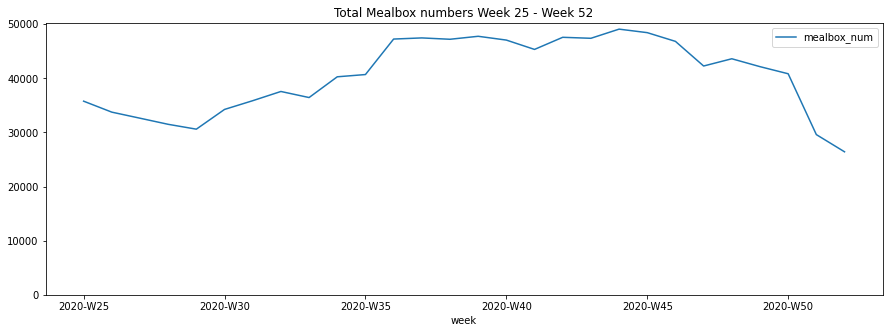

In [19]:
final_mealboxes.groupby('week').sum().plot(ylim=0,figsize=(15, 5),title='Total Mealbox numbers Week 25 - Week 52')

Looking at the above plot for total mealbox numbers for the remainder of the year, we can see a clear upwards trend from week 30 to week 35 onwards, with total mealbox numbers plateauing around 48,000 boxes in total. Towards the Christmas break then in week 52 we can see a significant drop in total mealboxes as customers likely pause their subscriptions while going on their end-of-year holidays.

## Fitting a linear model to predict final numbers for each add-on product

It seems like a reasonable assumptions that, on average, orders for add-on products will move in the same direction as orders for standard mealboxes. Therefore, in order to capture the trend of standard mealboxes and their relationship to final add-on numbers, I will begin by again fitting a linear regression model that takes mealbox numbers, delivery day, island and add-on time and outputs an estimate of final add-on numbers for each add-on type, delivery day and island combination.

Daily numbers for week 25-32 on the other hand likely would not be helpful in explaining these longer-term trends and I will not be including those in the model.


In [20]:
final_nd = final.drop(['day1','day2','day3','day4','day5','day6'],axis=1)
final_nd = final_nd.loc[final_nd['week'] != '2020-W33'].set_index(['week','delivery_day','island'])
final_nd.head()

addon_type production_day  final_number
week     delivery_day island                                         
2020-W25 Saturday     North       brunch         Friday          24.0
                      North     desserts         Friday         197.0
                      North   fruitboxes         Friday          43.0
                      North        lunch         Friday          22.0
                      North        sides         Friday         119.0

In [21]:
final_mealboxes = pd.read_csv('../boxes_final.csv').drop(['box_type','production_day'],axis=1)
final_mealboxes.head()
final_mealboxes.rename(columns={'box_nr':'mealbox_num'}, inplace=True)

final_mealboxes_train = final_mealboxes.loc[final_mealboxes['week'].isin(['2020-W25','2020-W26','2020-W27',
                                                                          '2020-W28','2020-W29','2020-W30',
                                                                          '2020-W31','2020-W32'])]
final_mealboxes_train = final_mealboxes_train.set_index(['week','delivery_day','island'])
complete_df = pd.merge(final_nd,final_mealboxes_train,how='outer',
                    on=['week','delivery_day','island'])
complete_df = complete_df.reset_index()
complete_df['final_number'] = complete_df['final_number'].apply(lambda x: int(x))
complete_df = complete_df[(complete_df != 0).all(1)]
complete_df.head()

,week,delivery_day,island,addon_type,production_day,final_number,mealbox_num
0,2020-W25,Saturday,North,brunch,Friday,24,5942
1,2020-W25,Saturday,North,desserts,Friday,197,5942
2,2020-W25,Saturday,North,fruitboxes,Friday,43,5942
3,2020-W25,Saturday,North,lunch,Friday,22,5942
4,2020-W25,Saturday,North,sides,Friday,119,5942


Now the data is in the correct format to fit a linear model

In [170]:
train = pd.get_dummies(complete_df.drop('week',axis=1))

x_train = train.drop('final_number', axis = 1)
y_train = train.loc[:,'final_number']

LR2 = LinearRegression()
tree2 = DecisionTreeRegressor()
knn2 = KNeighborsRegressor()
rf2 = RandomForestRegressor()
gbc2 = GradientBoostingClassifier()

cvs_lin = cross_val_score(LR2, x_train, y_train, cv=10, scoring='neg_mean_squared_error')
cvs_tree = cross_val_score(tree2, x_train, y_train, cv=10, scoring='neg_mean_squared_error')
cvs_knn = cross_val_score(knn2, x_train, y_train, cv=10, scoring='neg_mean_squared_error')
cvs_rf = cross_val_score(rf2, x_train, y_train, cv=10, scoring='neg_mean_squared_error')
cvs_gbc = cross_val_score(gbc2, x_train, y_train, cv=10, scoring='neg_mean_squared_error')
    
print("Average RMSE for the Linear Model: ",np.sqrt(-cvs_lin).mean())
print("Average RMSE for the Decision Tree Model: ",np.sqrt(-cvs_tree).mean())
print("Average RMSE for the KNN Model: ",np.sqrt(-cvs_knn).mean())
print("Average RMSE for the Random Forest Model: ",np.sqrt(-cvs_rf).mean())
print("Average RMSE for the Gradient Boosting Model: ",np.sqrt(-cvs_gbc).mean())

/Users/lawrence/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Average RMSE for the Linear Model:  22.643092337495876
Average RMSE for the Decision Tree Model:  22.072213871352368
Average RMSE for the KNN Model:  39.66910958252187
Average RMSE for the Random Forest Model:  17.681702721821548
Average RMSE for the Gradient Boosting Model:  22.718727737039252


Again, it appears that tree based models work best in this case, with the random forest regressor scoring best with a RMSE of 15.4, followed by the decision tree with a RMSE of 17.7 and the linear regression model with a rmse of 23.

Let's see if we can fine-tune the random forest model's parameters a little to further improve performance:

In [171]:
from sklearn.model_selection import GridSearchCV
rf = RandomForestRegressor()
params = { 
    'n_estimators': [5,10,20,50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(4,16)]
}

grid_search = GridSearchCV(estimator=rf, cv=10, param_grid=params, scoring = 'neg_mean_squared_error')
grid_search.fit(x_train, y_train)

print(np.sqrt(-grid_search.best_score_))
print(grid_search.best_estimator_)

16.35251763554024
RandomForestRegressor(max_depth=8, max_features='log2', n_estimators=50)


This is a decent improvement from the initial cross-validated mean squared prediction error. This seems like a reasonably good prediction score and I will use this to make my final predictions for the final numbers for the remaining weeks of the year.

In [172]:
final_rf=grid_search.best_estimator_
final_rf.fit(x_train, y_train)

final_nd = final.drop(['week','final_number','day1','day2','day3','day4','day5','day6'],axis=1).set_index(['delivery_day','island'])


final_mealboxes_pred = final_mealboxes.loc[~final_mealboxes['week'].isin(['2020-W25','2020-W26','2020-W27',
                                                                          '2020-W28','2020-W29','2020-W30',
                                                                          '2020-W31','2020-W32'])].set_index(['delivery_day','island'])

complete_df = pd.merge(final_nd,final_mealboxes_pred,how='outer',
                    on=['delivery_day','island'])
complete_df = complete_df.reset_index().sort_values('week').set_index('week')

pred_vals = pd.get_dummies(complete_df)

final_preds = final_rf.predict(pred_vals)
complete_df['final_estimated_numbers'] = np.round(final_preds)
complete_df = complete_df.reset_index()
complete_df.head()

,week,delivery_day,island,addon_type,mealbox_num,final_estimated_numbers
0,2020-W33,Saturday,North,brunch,6033,36.0
1,2020-W33,Monday,North,ready-to-heat,4178,59.0
2,2020-W33,Sunday,South,soups,4630,61.0
3,2020-W33,Monday,North,lunch,4178,9.0
4,2020-W33,Monday,North,fruitboxes,4178,26.0
